In [2]:
%reset
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
from matplotlib.pyplot import cm
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
# solves G''(z) + (N^2(z) - omega^2)G(z)/c^2 = 0 G is vertical structure of isopycnal displacement, units m.
#dG/dz = F(z) (here called Gz), vertical structure of horizontal velocity and is unitless

#   subject to G'(0) = gG(0)/c^2 (free surface) & G(-D) = 0 (flat bottom)
# G(z) is normalized so that the vertical integral of (G'(z))^2 is D
# G' is dimensionless, G has dimensions of length

# - N is buoyancy frequency [s^-1] (nX1 vector)
# - depth [m] (maximum depth is considered the sea floor) (nX1 vector)
# - omega is frequency [s^-1] (scalar)
# - mmax is the highest baroclinic mode calculated
# - m=0 is the barotropic mode
# - 0 < m <= mmax are the baroclinic modes
# - Modes are calculated by expressing in finite difference form 1) the
#  governing equation for interior depths (rows 2 through n-1) and 2) the
#  boundary conditions at the surface (1st row) and the bottome (last row).
# - Solution is found by solving the eigenvalue system A*x = lambda*B*x
def vertical_modes(N2_0, Depth, omega, mmax):
    z = -1 * Depth

    if np.size(np.shape(N2_0)) > 1:
        N2 = np.nanmean(N2_0, axis=1)
    else:
        N2 = N2_0

    n = np.size(z)
    nm1 = n - 1
    nm2 = n - 2
    gravity = 9.82
    # ----- vertical increments
    dz = np.concatenate([[0], z[1:] - z[0:nm1]])  # depth increment [m]
    dzm = np.concatenate([[0], 0.5 * (z[2:] - z[0:nm2]), [0]])  # depth increment between midpoints [m]
    # ----- sparse matrices
    # A = row pos, B = col pos, C = val  
    A = np.concatenate([[0], [0], np.arange(1, nm1), np.arange(1, nm1), np.arange(1, nm1), [n - 1]])
    B = np.concatenate([[0], [1], np.arange(1, nm1), np.arange(0, nm2), np.arange(2, n), [n - 1]])
    C = np.concatenate(
        [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
         -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
        # [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
        #  -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
    mat1 = coo_matrix((C, (A, B)), shape=(n, n))

    D = np.concatenate([[0], np.arange(1, n)])
    E = np.concatenate([[0], np.arange(1, n)])
    F = np.concatenate([[gravity], N2[1:] - omega * omega])  # originially says N2[1:,10]
    mat2 = coo_matrix((F, (D, E)), shape=(n, n))

    # compute eigenvalues and vectors 
    vals, vecs = eigs(mat1, k=mmax + 1, M=mat2, sigma=0)
    eigenvalue = np.real(vals)
    wmodes = np.real(vecs)
    s_ind = np.argsort(eigenvalue)
    eigenvalue = eigenvalue[s_ind]
    wmodes = wmodes[:, s_ind]
    m = np.size(eigenvalue)
    c = 1 / np.sqrt(eigenvalue)  # kelvin wave speed
    # normalize mode (shapes)
    Gz = np.zeros(np.shape(wmodes))
    G = np.zeros(np.shape(wmodes))
    for i in range(m):
        dw_dz = np.nan * np.ones(np.shape(z))
        dw_dz[0] = (wmodes[1, i] - wmodes[0, i]) / (z[1] - z[0])
        dw_dz[-1] = (wmodes[-1, i] - wmodes[-2, i]) / (z[-1] - z[-2])
        for j in range(1, len(z) - 1):
            dw_dz[j] = (wmodes[j + 1, i] - wmodes[j - 1, i]) / (z[j + 1] - z[j - 1])
        # dw_dz = np.gradient(wmodes[:, i], z)
        norm_constant = np.sqrt(np.trapz((dw_dz * dw_dz), (-1 * z)) / (-1 * z[-1]))
        # norm_constant = np.abs(np.trapz(dw_dz * dw_dz, z) / Depth.max())

        if dw_dz[0] < 0:
            norm_constant = -1 * norm_constant
        Gz[:, i] = dw_dz / norm_constant

        norm_constant_G = np.sqrt(np.trapz((wmodes[:, i] * wmodes[:, i]), (-1 * z)) / (-1 * z[-1]))
        G[:, i] = wmodes[:, i] / norm_constant

    #epsilon = np.nan * np.zeros((5, 5, 5))  # barotropic and first 5 baroclinic
    #for i in range(0, 5):  # i modes
    #    for j in range(0, 5):  # j modes
    #        for m in range(0, 5):  # k modes
    #            epsilon[i, j, m] = np.trapz((Gz[:, i] * Gz[:, j] * Gz[:, m]), -1.0*z) / (-1.0*z[-1])

    return G, Gz, c#, epsilon
#G is the displacement modes and Gz is velocity modes (Gz = dG/dz = F)

## Computing QG modes at an individual gridbox. 


In [8]:
#1/4 degree resolution
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
#av = xr.open_dataset('averages_00031502.nc', decode_times=False)
av1=xr.open_mfdataset(['averages_00030002.nc'],decode_times=False,decode_cf = False)
av2=xr.open_mfdataset(['averages_00030502.nc'],decode_times=False,decode_cf = False)
av3=xr.open_mfdataset(['averages_00031002.nc'],decode_times=False,decode_cf = False)
av4=xr.open_mfdataset(['averages_00031502.nc'],decode_times=False,decode_cf = False)


/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.25deg_N15_baseline_hmix5


In [19]:
#1/32 degree resolution
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
                        'sub05/ocean.stats.nc','sub06/ocean.stats.nc','sub07/ocean.stats.nc','sub08/ocean.stats.nc',
                        'sub09/ocean.stats.nc','sub10/ocean.stats.nc','sub11/ocean.stats.nc','sub12/ocean.stats.nc',
                        'sub13/ocean.stats.nc','sub14/ocean.stats.nc','sub15/ocean.stats.nc','sub16/ocean.stats.nc',
                        'sub17/ocean.stats.nc','sub18/ocean.stats.nc','sub19/ocean.stats.nc','sub20/ocean.stats.nc'], decode_times=False)
#av = xr.open_dataset('averages_00002702.nc',decode_times=False)
av = xr.open_mfdataset(['averages_00002302.nc','averages_00002402.nc','averages_00002502.nc','averages_00002602.nc','averages_00002702.nc'], decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.03125deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [20]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
Coriolis = fs['Coriolis'].values

xh = fs.xh.values
yh = fs.yh.values

In [28]:
##Indices for 1/4 degree case:
#For Northern part of the domain:
#index_lon=60; index_lat=460
##For ACC:
# index_lon=60; index_lat=80

##Indices for 1/32 degree case:
index_lon=480; index_lat=3680
##For ACC:
# index_lon=480; index_lat=640

f_local = np.abs(Coriolis[index_lat+1,index_lon+1])
print(f_local)

0.0001031821


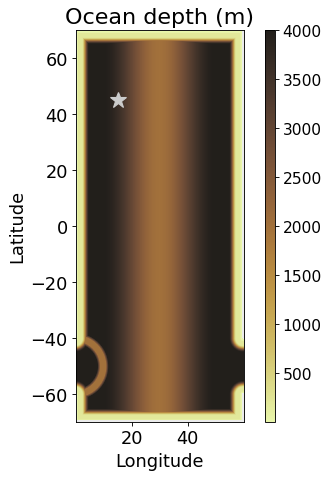

In [29]:
#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,depth,cmap=cmocean.cm.turbid)
ax1.plot(xh[index_lon],yh[index_lat],'*',markersize=15,color=[0.8, 0.8, 0.8])
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

## For 1/4 degree run:

In [16]:
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(xh),1]);   Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)
eta = np.zeros([100,len(Layer)+1]);

BT_KE=np.zeros(400)
BC_KE=np.zeros(400)
KE_u_t=np.zeros([400,15])
KE_v_t=np.zeros([400,15])
BC_PE=np.zeros(400)
PE_t=np.zeros([400,15])
wavenumbers = np.zeros([15,5])

av_list = [av1,av2,av3,av4]
for dsi in range(1,5):
    av = av_list[dsi-1]
    v = np.nanmean(np.array(av['v'][:,:,index_lat-1:index_lat+1,index_lon]),axis=2);
    u = np.nanmean(np.array(av['u'][:,:,index_lat,index_lon-1:index_lon+1]),axis=2); 
    v=np.column_stack([v, 0.0*v[:,-1]]); u=np.column_stack([u, 0.0*u[:,-1]]) #add bottom BC point where u,v,=0

    h = np.array(av['h'][:,:,index_lat,index_lon]);


    for i in range(1,len(Layer)+1):
        for j in range(0,100):
            eta[j,i]=np.nansum(h[j,0:i])  
        print(i)
    
    eta[:,:-1]=(eta[:,1:]+eta[:,:-1])/2. #add bottom BC point at topography where u,v=0

    
    
    drhodz=drho/h
    N2=(9.81/1022.6)*drhodz
    N2=np.column_stack([N2, N2[:,-1]*0.+1.e-7]) #add bottom BC point at topography where u,v=0, make the N2 small so it doesn't get filtered



    eta_mean = np.nanmean(eta,axis=0); N2_mean = np.nanmean(N2,axis=0)
    eta_prime= eta-eta_mean

    N2_mean[N2_mean>.1] =np.nan
    eta_filtered = eta_mean[~np.isnan(N2_mean)]
    N2_filtered  = N2_mean[~np.isnan(N2_mean)]

    
    
    nmodes = len(N2_filtered)-3
    #Limit the number of modes to be 7 or 10 if it's larger than that (otherwise keep number of modes)
    if ( nmodes >= 7 ):
        nmodes = 7
    
    [G, Gz, c]=vertical_modes(N2_filtered, eta_filtered, 0, nmodes) #nmodes is number of BC modes, doens't include BT mode
    wavenumbers[0:nmodes+1,dsi-1]=(1/c)*f_local
    
    for i in range(0,100):
        ui=u[i,~np.isnan(N2_mean)]; vi=v[i,~np.isnan(N2_mean)];
        eta_prime_i=eta_prime[i,~np.isnan(N2_mean)];
    
    
        amp_u=np.linalg.lstsq(Gz,ui)[0]
        amp_v=np.linalg.lstsq(Gz,vi)[0]  #solving for alpha, units of m/s
        amp_eta=np.linalg.lstsq(G,eta_prime_i)[0] #solving for Beta, unitless

        BT_KE[i+100*(dsi-1)]=0.5*amp_u[0]**2+0.5*amp_v[0]**2
        BC_KE[i+100*(dsi-1)]=np.nansum(0.5*amp_u[1:]**2)+np.nansum(0.5*amp_v[1:]**2)
        BC_PE[i+100*(dsi-1)]=np.nansum(0.5*(amp_eta[1:]**2)*(c[1:]**2)) 
    
        KE_u_t[i+100*(dsi-1),0:nmodes+1]=0.5*amp_u[:]**2 #has modes 
        KE_v_t[i+100*(dsi-1),0:nmodes+1]=0.5*amp_v[:]**2
        PE_t[i+100*(dsi-1),1:nmodes+1]=(0.5*amp_eta[1:]**2)*c[1:]**2 
    
wavenumbers = np.nanmean(wavenumbers,axis=1)
print('done')
#

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
done


## For 1/32 degree case

In [30]:
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(xh),1]);   Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)
eta = np.zeros([100,len(Layer)+1]);

BT_KE=np.zeros(100)
BC_KE=np.zeros(100)
KE_u_t=np.zeros([100,15])
KE_v_t=np.zeros([100,15])
BC_PE=np.zeros(100)
PE_t=np.zeros([100,15])
wavenumbers = np.zeros(15)



v = np.nanmean(np.array(av['v'][:,:,index_lat-1:index_lat+1,index_lon]),axis=2);
u = np.nanmean(np.array(av['u'][:,:,index_lat,index_lon-1:index_lon+1]),axis=2); 
v=np.column_stack([v, 0.0*v[:,-1]]); u=np.column_stack([u, 0.0*u[:,-1]]) #add bottom BC point where u,v,=0

h = np.array(av['h'][:,:,index_lat,index_lon]);


for i in range(1,len(Layer)+1):
    for j in range(0,100):
        eta[j,i]=np.nansum(h[j,0:i])  
    print(i)
    
eta[:,:-1]=(eta[:,1:]+eta[:,:-1])/2. #add bottom BC point at topography where u,v=0

drhodz=drho/h
N2=(9.81/1022.6)*drhodz
N2=np.column_stack([N2, N2[:,-1]*0.+1.e-7]) #add bottom BC point at topography where u,v=0, make the N2 small so it doesn't get filtered



eta_mean = np.nanmean(eta,axis=0); N2_mean = np.nanmean(N2,axis=0)
eta_prime= eta-eta_mean

N2_mean[N2_mean>.1] =np.nan
eta_filtered = eta_mean[~np.isnan(N2_mean)]
N2_filtered  = N2_mean[~np.isnan(N2_mean)]

    
    
nmodes = len(N2_filtered)-3
#Limit the number of modes to be 7 or 10 if it's larger than that (otherwise keep number of modes)
if ( nmodes >= 7 ):
    nmodes = 7
    
[G, Gz, c]=vertical_modes(N2_filtered, eta_filtered, 0, nmodes) #nmodes is number of BC modes, doens't include BT mode
wavenumbers[0:nmodes+1]=(1/c)*f_local
    
for i in range(0,100):
    ui=u[i,~np.isnan(N2_mean)]; vi=v[i,~np.isnan(N2_mean)];
    eta_prime_i=eta_prime[i,~np.isnan(N2_mean)];
    
    
    amp_u=np.linalg.lstsq(Gz,ui)[0]
    amp_v=np.linalg.lstsq(Gz,vi)[0]  #solving for alpha, units of m/s
    amp_eta=np.linalg.lstsq(G,eta_prime_i)[0] #solving for Beta, unitless

    BT_KE[i]=0.5*amp_u[0]**2+0.5*amp_v[0]**2
    BC_KE[i]=np.nansum(0.5*amp_u[1:]**2)+np.nansum(0.5*amp_v[1:]**2)
    BC_PE[i]=np.nansum(0.5*(amp_eta[1:]**2)*(c[1:]**2)) 
    
    KE_u_t[i,0:nmodes+1]=0.5*amp_u[:]**2 #has modes 
    KE_v_t[i,0:nmodes+1]=0.5*amp_v[:]**2
    PE_t[i,1:nmodes+1]=(0.5*amp_eta[1:]**2)*c[1:]**2 
    
print('done')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
done


In [18]:
xKE025 = np.linspace(0,14,15); 
xKE025[0]=.9
ampKE025 = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers025=wavenumbers

xPE025 = np.linspace(1,14,14)
ampPE025 = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE

nmodes025 = nmodes
print('done')

done


In [33]:
xKE003125 = np.linspace(0,14,15); 
xKE003125[0]=.9
ampKE003125 = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers003125=wavenumbers

xPE003125 = np.linspace(1,14,14)
ampPE003125 = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE
nmodes003125 = nmodes
print('done')

done


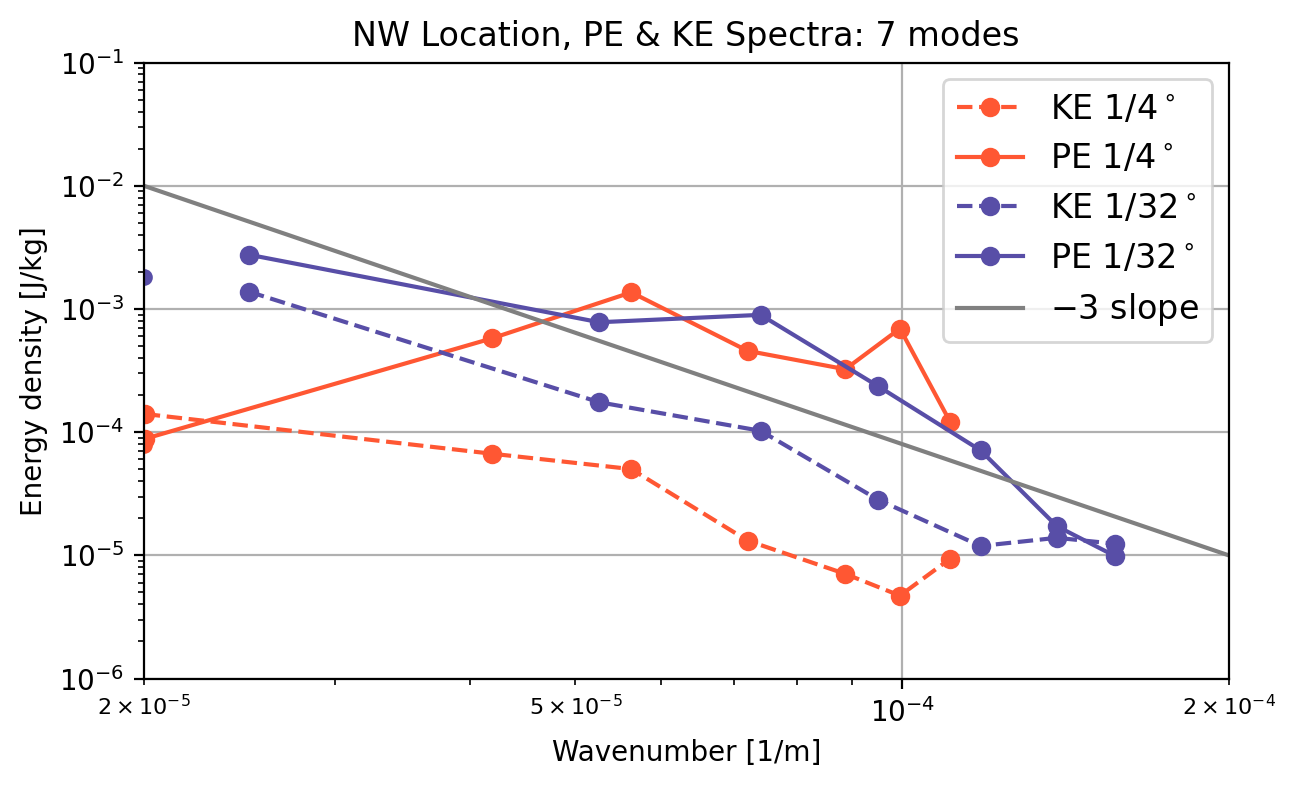

In [35]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(7,4), dpi= 200)
plt.style.use('default')

plt.loglog(abs(wavenumbers025[1:nmodes025+1]), (ampKE025[1:nmodes025+1]), '--o',color='#FF5733')
plt.loglog(abs(wavenumbers025[1:nmodes025+1]), (ampPE025[0:nmodes025]),'-o',color='#FF5733')


plt.loglog((wavenumbers003125[1:nmodes003125+1]), (ampKE003125[1:nmodes003125+1]), '--o',color='#584EA7')
plt.loglog((wavenumbers003125[1:nmodes003125+1]), (ampPE003125[0:nmodes003125]),'-o',color='#584EA7')

plt.plot([2e-5, 2e-4],[1e-2,1e-5],color=[0.5, 0.5, 0.5])

plt.loglog(2.e-5, ampKE025[0], 'o',color='#FF5733',Markersize=5)
# #plt.loglog(1.e-5, (ampKE00625[0]), 'o',color=[0,0,0],Markersize=5)
plt.loglog(2.e-5, (ampKE003125[0]), 'o',color='#584EA7',Markersize=5)

#plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlabel("Wavenumber [1/m]")
plt.ylabel("Energy density [J/kg]")
plt.title("NW Location, PE & KE Spectra: %i modes" % (nmodes025))
plt.xlim(2e-5,2e-4) #2e-5 to 2e-4 before
plt.ylim(1e-6,1e-1)

ax = plt.gca()
plt.tick_params(axis='x', which='minor')
ax.xaxis.set_ticklabels([r'$2\times10^{-4}$','','',r'$5\times10^{-4$}','','','','', 
       r'$2\times 10^{-5}$','','',r'$5\times10^{-5}$','','','','',
       r'$2\times 10^{-4}$'],minor=True,fontsize=8)



plt.legend(['KE 1/4$^\circ$','PE 1/4$^\circ$','KE 1/32$^\circ$','PE 1/32$^\circ$','$-3$ slope'],fontsize=12)
plt.grid()
#ax.set_aspect('equal')

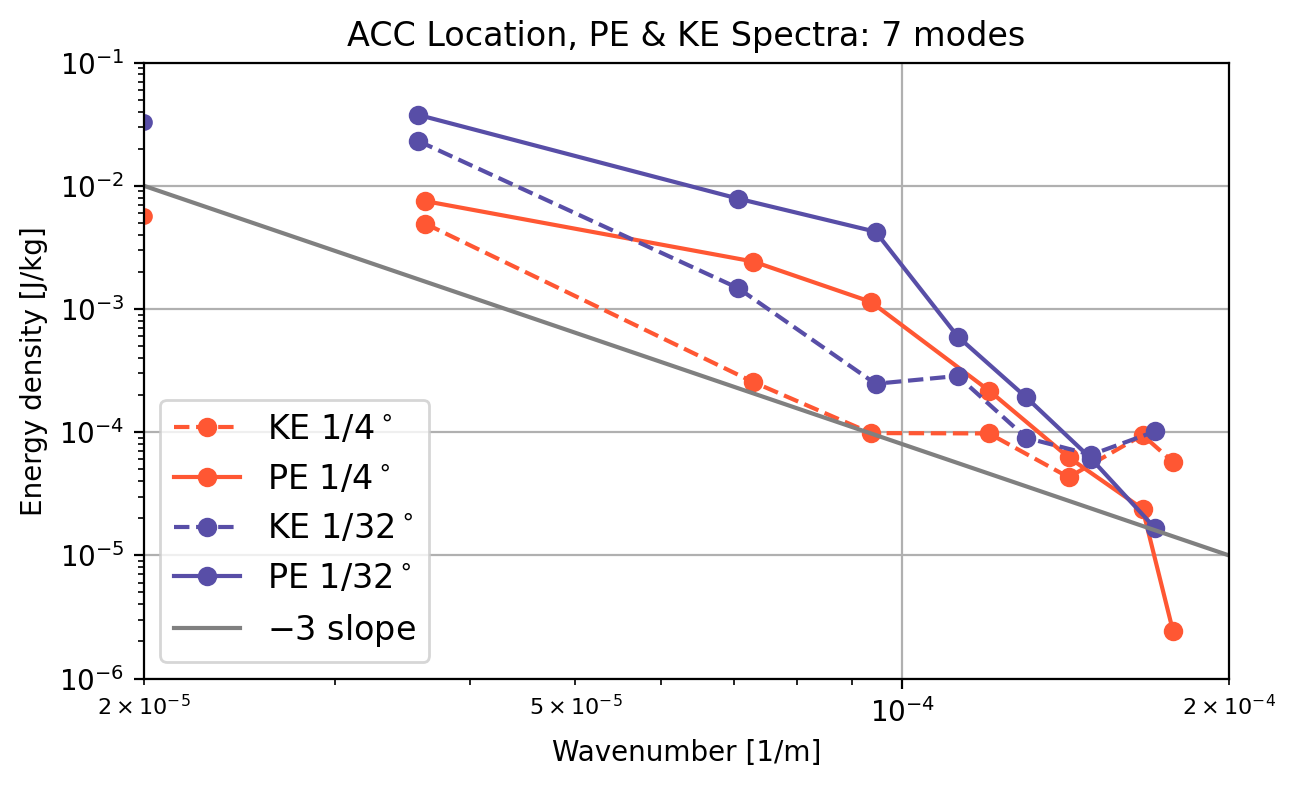

In [48]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(7,4), dpi= 200)
plt.style.use('default')

plt.loglog(abs(wavenumbers025[1:nmodes025+1]), (ampKE025[1:nmodes025+1]), '--o',color='#FF5733')
plt.loglog(abs(wavenumbers025[1:nmodes025+1]), (ampPE025[0:nmodes025]),'-o',color='#FF5733')


plt.loglog((wavenumbers003125[1:nmodes003125+1]), (ampKE003125[1:nmodes003125+1]), '--o',color='#584EA7')
plt.loglog((wavenumbers003125[1:nmodes003125+1]), (ampPE003125[0:nmodes003125]),'-o',color='#584EA7')

plt.plot([2e-5, 2e-4],[1e-2,1e-5],color=[0.5, 0.5, 0.5])

plt.loglog(2.e-5, ampKE025[0], 'o',color='#FF5733',Markersize=5)
# #plt.loglog(1.e-5, (ampKE00625[0]), 'o',color=[0,0,0],Markersize=5)
plt.loglog(2.e-5, (ampKE003125[0]), 'o',color='#584EA7',Markersize=5)

#plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlabel("Wavenumber [1/m]")
plt.ylabel("Energy density [J/kg]")
plt.title("ACC Location, PE & KE Spectra: %i modes" % (nmodes025))
plt.xlim(2e-5,2e-4) #2e-5 to 2e-4 before
plt.ylim(1e-6,1e-1)

ax = plt.gca()
plt.tick_params(axis='x', which='minor')
ax.xaxis.set_ticklabels([r'$2\times10^{-4}$','','',r'$5\times10^{-4$}','','','','', 
       r'$2\times 10^{-5}$','','',r'$5\times10^{-5}$','','','','',
       r'$2\times 10^{-4}$'],minor=True,fontsize=8)



plt.legend(['KE 1/4$^\circ$','PE 1/4$^\circ$','KE 1/32$^\circ$','PE 1/32$^\circ$','$-3$ slope'],fontsize=12)
plt.grid()
#ax.set_aspect('equal')